In [1]:
import numpy as np
import pickle
import glob
import matplotlib.pyplot as plt
import os

from scipy.special import entr # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.entr.html
from keras.utils import to_categorical
import keras.metrics as metrics
from kf_impl import EKF_CV_MODEL
from lstm_impl import CombinedLSTM
import pdb

Using TensorFlow backend.


### Data Loading

In [2]:
# The function to extract training data from pickles
def extract_data(pklfile, crop=None):
    with open(pklfile, 'rb') as f:
        dataset_all = pickle.load(f)
        
    # All the history trajectoreis (x, y, heading), with shape (batch_size, sequence_length, feature_dims)
    history_traj_data = np.array(dataset_all['features'])[:, :, :]

    # All the future trajectoreis (x, y, heading), with shape (batch_size, sequence_length, feature_dims)
    future_traj_data = np.array(dataset_all['labels'])[:, :, :-1]

    # All the goal positins and occupancy (x, y, occup), with shape (batch_size, (goal_nums * feature_dims))
    goals_position = np.array(dataset_all['goals'])
    goals_position = goals_position.reshape((goals_position.shape[0], goals_position.shape[1] * goals_position.shape[2]))

    # All intention labels, with shape (batch_size, goal_nums)
    goal_idx = np.array(dataset_all['labels'])[:, 0, -1]
    # Convert to one-hot and the last one is undecided (-1)
    one_hot_goal = to_categorical(goal_idx, num_classes=33)
    
    if crop is not None:
        raise NotImplementedError("TODO")
    
    return history_traj_data, future_traj_data, goals_position, one_hot_goal

In [3]:
def build_train_test_splits(pklfiles_to_process, num_pkl_folds=5):
    # Using a suboptimal approach here:
    # Just build a list of dictionaries, where entry_i 
    # corresponds to train split i.

    train_sets = []
    test_sets  = []
    
    
    inds = np.arange(num_pkl_folds)
    
    for hold_out_ind in inds:
        train_inds = np.delete(inds, hold_out_ind)
        
        train_set = {"history_traj_data" : None,
                     "future_traj_data"  : None,
                     "goal_position"     : None,
                     "one_hot_goal"      : None}

        test_set  = {"history_traj_data" : None,
                     "future_traj_data"  : None,
                     "goal_position"     : None,
                     "one_hot_goal"      : None}
        
        # Train Set
        for fold in train_inds:
            search_str = 'fold_%d' % fold
            search_res = np.argwhere([search_str in f for f in pklfiles_to_process])
            assert(len(search_res) == 1)
            file_num = search_res[0][0]
            history_traj_data, future_traj_data, goals_position, one_hot_goal = extract_data(pklfiles_to_process[file_num])

            if train_set['history_traj_data'] is None:
                train_set['history_traj_data'] = history_traj_data
                train_set['future_traj_data']  = future_traj_data
                train_set['goal_position']     = goals_position
                train_set['one_hot_goal']      = one_hot_goal         
            else:
                train_set['history_traj_data'] = np.append(train_set['history_traj_data'], history_traj_data, axis=0)
                train_set['future_traj_data']  = np.append(train_set['future_traj_data'], future_traj_data, axis=0)
                train_set['goal_position']     = np.append(train_set['goal_position'], goals_position, axis=0)
                train_set['one_hot_goal']      = np.append(train_set['one_hot_goal'], one_hot_goal, axis=0)

        # Test Set
        for fold in [hold_out_ind]:
            search_str = 'fold_%d' % fold
            search_res = np.argwhere([search_str in f for f in pklfiles_to_process])
            assert(len(search_res) == 1)
            file_num = search_res[0][0]
            history_traj_data, future_traj_data, goals_position, one_hot_goal = extract_data(pklfiles_to_process[file_num])

            if test_set['history_traj_data'] is None:
                test_set['history_traj_data'] = history_traj_data
                test_set['future_traj_data']  = future_traj_data
                test_set['goal_position']     = goals_position
                test_set['one_hot_goal']      = one_hot_goal         
            else:
                test_set['history_traj_data'] = np.append(test_set['history_traj_data'], history_traj_data, axis=0)
                test_set['future_traj_data']  = np.append(test_set['future_traj_data'], future_traj_data, axis=0)
                test_set['goal_position']     = np.append(test_set['goal_position'], goals_position, axis=0)
                test_set['one_hot_goal']      = np.append(test_set['one_hot_goal'], one_hot_goal, axis=0)
                
        train_sets.append(train_set)
        test_sets.append(test_set)
        
    return train_sets, test_sets

### Metrics

In [4]:
def dist_by_timestep(traj_pred, traj_actual):
    # returns avg, min, max distance error across each timestep
    diff = traj_pred - traj_actual # N by N_pred by 2
    diff_xy_norm = np.linalg.norm(diff, axis=2)
    return np.mean(diff_xy_norm, axis=0), np.min(diff_xy_norm, axis = 0), np.max(diff_xy_norm, axis=0)

def top_k_accuracy(goal_pred, goal_actual, k=1):
    # returns empirical probability of the real goal being contained
    # in the top k most likely goal set from goal_pred.
    return np.mean(metrics.top_k_categorical_accuracy(goal_actual, goal_pred, k=k))

def mean_entropy(goal_pred):
    # returns the avg. entropy of the goal prediction dist.
    # higher entropy indicates more uncertain predictions
    N = goal_pred.shape[0]
    
    entr_matrix = entr(goal_pred)
    entr_by_instance = np.sum(entr_matrix, axis=1) #entropy by snippet
    return np.mean(entr_by_instance)

### Train and Save Models and Results

In [6]:
# Construct the evaluation datasets.
MODE = 'LOAD' # 'TRAIN' or 'LOAD'
res_filename = 'model_comparison_dict.pkl'

pklfiles_to_process = glob.glob('./dataset/*.pkl')
pklfiles_to_process.sort()
train_sets, test_sets = build_train_test_splits(pklfiles_to_process, num_pkl_folds=5)

# Build the model bank.
models = [EKF_CV_MODEL(x_init=np.zeros(5), P_init=np.eye(5), R=np.diag([1e-3]*3), dt=0.1)]
names =  ['EKF_CV']

# Create saving directories.
if not os.path.exists('./model'):
    os.makedirs('./model')
if not os.path.exists('./results'):
    os.makedirs('./results')

# Build Trajectory Model
# history_shape = train_sets[0]['history_traj_data'].shape
# goal_position_shape = train_sets[0]['goal_position'].shape
# one_hot_goal_shape = train_sets[0]['one_hot_goal'].shape
# future_shape = train_sets[0]['future_traj_data'].shape
# Hard coded for now, need to make this more robust:
history_shape       = (None, 5, 3)
goal_position_shape = (None, 32*3)
one_hot_goal_shape  = (None, 32+1)
future_shape        = (None, 20, 2)

for hidden_dim in [50, 100, 200]:
    for beta in [0.001, 0.1, 1.0]:
        models.append(
            CombinedLSTM(history_shape,
                         goal_position_shape,
                         one_hot_goal_shape,
                         future_shape,
                         hidden_dim,
                         beta=beta)
        )
    
        names.append('LSTM_h%d_b%.3f' % (hidden_dim, beta))
            
model_res_dict = {} # same indexing/length as names/models
if MODE is 'TRAIN':
    for name, model in zip(names, models):
        metric_dict = {}
        metric_dict['train'] = {'N_instances'   : [],
                                'traj_dist_vs_N': [],
                                'goal_top_1_acc': [], 
                                'goal_top_3_acc': [],
                                'goal_top_5_acc': [],
                                'goal_entropy'  : []}
        metric_dict['test']  = {'N_instances'   : [],
                                'traj_dist_vs_N': [],
                                'goal_top_1_acc': [], 
                                'goal_top_3_acc': [],
                                'goal_top_5_acc': [],
                                'goal_entropy'  : []}

        for i_fold, (train_set, test_set) in enumerate(zip(train_sets, test_sets)):
            print('Training %s, Fold %d' % (name, i_fold))
            model.fit(train_set, test_set)
            train_goal_pred, train_traj_pred = model.predict(train_set)
            model.save('./model/%s_fold%d' % (name, i_fold))

            for tkey, tset in zip(['train', 'test'], [train_set, test_set]):
                goal_pred, traj_pred = model.predict(tset)
                N_instances = goal_pred.shape[0]
                #print(N_instances)

                meand, mind, maxd = dist_by_timestep(traj_pred, tset['future_traj_data'][:,:,:2])

                t1 = top_k_accuracy(goal_pred, tset['one_hot_goal'], k=1)
                t3 = top_k_accuracy(goal_pred, tset['one_hot_goal'], k=3)
                t5 = top_k_accuracy(goal_pred, tset['one_hot_goal'], k=5)

                ment = mean_entropy(goal_pred)
                metric_dict[tkey]['N_instances'].append(N_instances)
                metric_dict[tkey]['traj_dist_vs_N'].append(meand)
                metric_dict[tkey]['goal_top_1_acc'].append(t1)
                metric_dict[tkey]['goal_top_3_acc'].append(t3)
                metric_dict[tkey]['goal_top_5_acc'].append(t5)
                metric_dict[tkey]['goal_entropy'].append(ment)

                # TODO: save predictions/labels?

        model_res_dict[name] = metric_dict

    # save the model_res_dict to ./results
    filename = 'model_comparison_dict.pkl'
    pickle.dump(model_res_dict, open('./results/%s' % res_filename, 'wb'))
elif MODE is 'LOAD':
    # TODO: maybe load models if needed?
    model_res_dict = pickle.load(open('./results/%s' % res_filename, 'rb'))
else:
    raise ValueError("Invalid mode!")

### Analysis and Visualization

In [7]:
'''
TODOS:
(0) using predicted goals for LSTM model, instead of the real one.  Multimodal metric?
(1) traj_dist_vs_N plot with std dev shading using seaborn.lineplot and pandas
(2) top K% accuracy plot with k on x-axis, % on y-axis, and groups with error bars
(3) entropy of the various models
(4) code check

Writing TODOs:
(1) Methods: Tuesday (slides)
(2) Results: Monday
(3) Abstract/Conclusion: Wednesday
(4) Thursday to edit and submit
'''
''' Old code for reference
for name, mdict in zip(names, metric_dicts):
    print('Model: ', name)
    print('\tTop 1: ')
    print('\t\tMean: ', np.mean(mdict['goal_top_1_acc']))
    print('\t\tStd: ' , np.std(mdict['goal_top_1_acc']))
    print('\t\tMin: ' , np.min(mdict['goal_top_1_acc']))
    print('\t\tMin: ' , np.max(mdict['goal_top_1_acc']))
    
    print('\tTop 3: ')
    print('\t\tMean: ', np.mean(mdict['goal_top_3_acc']))
    print('\t\tStd: ' , np.std(mdict['goal_top_3_acc']))
    print('\t\tMin: ' , np.min(mdict['goal_top_3_acc']))
    print('\t\tMin: ' , np.max(mdict['goal_top_3_acc']))
    
    print('\tTop 5: ')
    print('\t\tMean: ', np.mean(mdict['goal_top_5_acc']))
    print('\t\tStd: ' , np.std(mdict['goal_top_5_acc']))
    print('\t\tMin: ' , np.min(mdict['goal_top_5_acc']))
    print('\t\tMin: ' , np.max(mdict['goal_top_5_acc']))
    
    print('\tEntropy: ')
    print('\t\tMean: ', np.mean(mdict['goal_entropy']))
    print('\t\tStd: ' , np.std(mdict['goal_entropy']))
    print('\t\tMin: ' , np.min(mdict['goal_entropy']))
    print('\t\tMin: ' , np.max(mdict['goal_entropy']))
    
    N_pred = 20 # hard coded for now
    
    for i_fold in range(len(test_sets)):
        if 'EKF' in name:
            plt.plot(np.arange(N_pred), mdict['traj_dist_vs_N'][i_fold], 'k')
        else:
            plt.plot(np.arange(N_pred), mdict['traj_dist_vs_N'][i_fold], 'b')

plt.title('Avg. Distance Error vs. Timestep')
plt.xlabel('Timestep k')
plt.ylabel('Distance Error (m)')
plt.show()
'''

" Old code for reference\nfor name, mdict in zip(names, metric_dicts):\n    print('Model: ', name)\n    print('\tTop 1: ')\n    print('\t\tMean: ', np.mean(mdict['goal_top_1_acc']))\n    print('\t\tStd: ' , np.std(mdict['goal_top_1_acc']))\n    print('\t\tMin: ' , np.min(mdict['goal_top_1_acc']))\n    print('\t\tMin: ' , np.max(mdict['goal_top_1_acc']))\n    \n    print('\tTop 3: ')\n    print('\t\tMean: ', np.mean(mdict['goal_top_3_acc']))\n    print('\t\tStd: ' , np.std(mdict['goal_top_3_acc']))\n    print('\t\tMin: ' , np.min(mdict['goal_top_3_acc']))\n    print('\t\tMin: ' , np.max(mdict['goal_top_3_acc']))\n    \n    print('\tTop 5: ')\n    print('\t\tMean: ', np.mean(mdict['goal_top_5_acc']))\n    print('\t\tStd: ' , np.std(mdict['goal_top_5_acc']))\n    print('\t\tMin: ' , np.min(mdict['goal_top_5_acc']))\n    print('\t\tMin: ' , np.max(mdict['goal_top_5_acc']))\n    \n    print('\tEntropy: ')\n    print('\t\tMean: ', np.mean(mdict['goal_entropy']))\n    print('\t\tStd: ' , np.s

                 Model  Split  Fold  Timestep  Distance Error
0               EKF_CV  train   0.0       0.0        0.047729
1               EKF_CV  train   0.0       1.0        0.077631
2               EKF_CV  train   0.0       2.0        0.109347
3               EKF_CV  train   0.0       3.0        0.147590
4               EKF_CV  train   0.0       4.0        0.189868
...                ...    ...   ...       ...             ...
1995  LSTM_h200_b1.000   test   4.0      15.0        0.697192
1996  LSTM_h200_b1.000   test   4.0      16.0        0.749155
1997  LSTM_h200_b1.000   test   4.0      17.0        0.803454
1998  LSTM_h200_b1.000   test   4.0      18.0        0.861544
1999  LSTM_h200_b1.000   test   4.0      19.0        0.921428

[2000 rows x 5 columns]


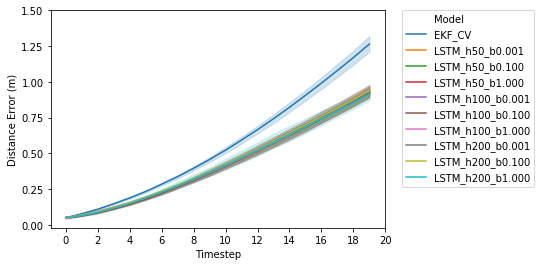

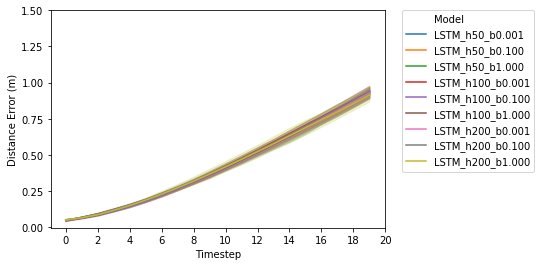

In [26]:
# PLOT 1: timestep vs. mean distance error
import pandas as pd
import seaborn as sns

data_list = []
timesteps = np.arange(20) # TODO: hard coded for now, change later.

for model in model_res_dict.keys():
    for split in model_res_dict[model].keys(): 
        # train/test
        traj_dist_vs_N = model_res_dict[model][split]['traj_dist_vs_N']
        for i_fold, td in enumerate(traj_dist_vs_N):
            for j_timestep, dist_timestep in enumerate(td):
                data_list.append([model, split, i_fold, j_timestep, dist_timestep])
            
traj_df = pd.DataFrame(data_list, columns=['Model', 'Split', 'Fold', 'Timestep', 'Distance Error'],dtype=float)
print(traj_df)

ax = sns.lineplot(x="Timestep", y="Distance Error", hue="Model", data=traj_df[traj_df.Split == 'test'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Distance Error (m)')
plt.xticks(np.arange(0, 21, step=2))
plt.yticks(np.arange(0, 1.51, step=0.25))
plt.show()

ax = sns.lineplot(x="Timestep", y="Distance Error", hue="Model", data=traj_df[(traj_df.Split == 'test') & \
                                                                              (traj_df.Model != 'EKF_CV')])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Distance Error (m)')
plt.xticks(np.arange(0, 21, step=2))
plt.yticks(np.arange(0, 1.51, step=0.25))
plt.show()

                Model  Split  Fold    k  Accuracy
0              EKF_CV  train   0.0  1.0  0.514894
1              EKF_CV  train   0.0  3.0  0.843972
2              EKF_CV  train   0.0  5.0  0.961702
3              EKF_CV  train   1.0  1.0  0.502128
4              EKF_CV  train   1.0  3.0  0.846099
..                ...    ...   ...  ...       ...
295  LSTM_h200_b1.000   test   3.0  3.0  0.985795
296  LSTM_h200_b1.000   test   3.0  5.0  0.994318
297  LSTM_h200_b1.000   test   4.0  1.0  0.869318
298  LSTM_h200_b1.000   test   4.0  3.0  0.974432
299  LSTM_h200_b1.000   test   4.0  5.0  0.994318

[300 rows x 5 columns]


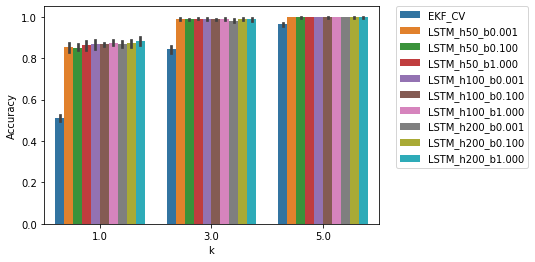

In [35]:
# PLOT 2: Top K accuracy
data_list = []
# timesteps = np.arange(20) # TODO: hard coded for now, change later.

for model in model_res_dict.keys():
    for split in model_res_dict[model].keys():
        #train/test
        
        goal_top_1_acc = model_res_dict[model][split]['goal_top_1_acc']
        goal_top_3_acc = model_res_dict[model][split]['goal_top_3_acc']
        goal_top_5_acc = model_res_dict[model][split]['goal_top_5_acc']
#         goal_entropy   = model_res_dict[model][split]['goal_entropy']
        
        for i_fold, (t1, t3, t5) in enumerate(zip(goal_top_1_acc, 
                                                       goal_top_3_acc,
                                                       goal_top_5_acc)):
            data_list.append([model, split, i_fold, 1, t1])
            data_list.append([model, split, i_fold, 3, t3])
            data_list.append([model, split, i_fold, 5, t5])
            
goal_df = pd.DataFrame(data_list, columns=['Model', 'Split', 'Fold', 'k', 'Accuracy'],dtype=float)
print(goal_df)

# Make a bar chart out of this.
ax = sns.barplot(x='k', y='Accuracy', hue='Model', data=goal_df[goal_df.Split == 'test'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()  


               Model  Split  Fold   Entropy
0             EKF_CV  train   0.0  1.590071
1             EKF_CV  train   1.0  1.591879
2             EKF_CV  train   2.0  1.600421
3             EKF_CV  train   3.0  1.591323
4             EKF_CV  train   4.0  1.583663
..               ...    ...   ...       ...
95  LSTM_h200_b1.000   test   0.0  0.128548
96  LSTM_h200_b1.000   test   1.0  0.106960
97  LSTM_h200_b1.000   test   2.0  0.124843
98  LSTM_h200_b1.000   test   3.0  0.180005
99  LSTM_h200_b1.000   test   4.0  0.123268

[100 rows x 4 columns]


No handles with labels found to put in legend.


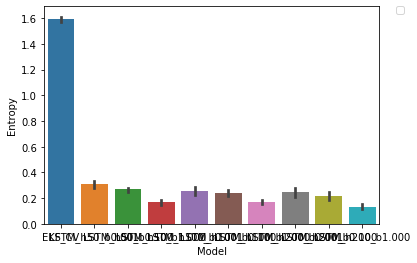

In [36]:
# PLOT 3: Entropy
data_list = []

for model in model_res_dict.keys():
    for split in model_res_dict[model].keys():
        #train/test
        goal_entropy   = model_res_dict[model][split]['goal_entropy']
        
        for i_fold, ent in enumerate(goal_entropy):
            data_list.append([model, split, i_fold, ent])
            
goal_df = pd.DataFrame(data_list, columns=['Model', 'Split', 'Fold', 'Entropy'],dtype=float)
print(goal_df)

# Make a bar chart out of this.
ax = sns.barplot(x='Model', y='Entropy', data=goal_df[goal_df.Split == 'test'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()  
